In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CS 282/')

In [ ]:
os.listdir()

['D_ITEMS.csv',
 'HW1',
 'HW3.ipynb',
 'HW2_code',
 'HW3 CS 282r.zip',
 'HW3_code_data.zip',
 'HW3',
 'D_ITEMS.csv.gz',
 'Checkpoint2',
 'Checkpoint-3',
 'lab-4-4-hileamlakB-master.zip']

In [ ]:
os.chdir('Final/Final project')

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from itertools import product

import sys, os

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

[0.4 0.6 1. ]


# LOADING THE DATA

In [ ]:
# if re_split:


aggr_df = pd.read_csv('mimic_iv_hypotensive_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
# create action bins (four actions in total)
aggr_df['action'] = aggr_df['bolus(binary)']*2 + aggr_df['vaso(binary)']
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
drop_columns = ['vaso(amount)','bolus(amount)',\
            'any_treatment(binary)','vaso(binary)','bolus(binary)']




In [ ]:
aggr_df

creatinine  \
stay_id  time                                                     
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)         NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)         2.7   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)         NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)         NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)         NaN   
...                                                         ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)         NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)         NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)         NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)         NaN   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)         NaN   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                       NaN   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   
...                                                                       ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)                       NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)                       NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)                       NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)                       0.8   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)                       NaN   

                                                     lactate  urine_output  \
stay_id  time                                                                
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)      NaN           NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)      NaN          40.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)      NaN         100.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)      1.7           NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)      NaN          40.0   
...                                                      ...           ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)      NaN          80.0   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)      NaN           NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)      NaN           NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)      NaN         150.0   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)      NaN         100.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      38.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   
...                                                                       ...   
39999230 [2147-09-03 17:31:28, 2147-09-03 18:31:28)                       NaN   
         [2147-09-03 18:31:28, 2147-09-03 19:31:28)                       NaN   
         [2147-09-03 19:31:28, 2147-09-03 20:31:28)                       NaN   
         [2147-09-03 20:31:28, 2147-09-03 21:31:28)                       NaN   
         [2147-09-03 21:31:28, 2147-09-03 22:31:28)                       NaN   

                                                     aspar

# LOOKING AT THE DATA

In [ ]:
print(len(aggr_df))
specific_stay_id = 30001446
len(aggr_df.loc[specific_stay_id])

355504


40

In [ ]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


#### standard normalization ####
normalize_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 'Cost']
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [ ]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()


In [ ]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()


In [ ]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

355504
355504
355504
355504


# Normalized version of the data

In [ ]:
data_df.head()

creatinine  \
stay_id  time                                                     
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)   -0.429737   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)   -0.429737   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)   -0.699695   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)   -0.699695   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)   -0.699695   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 -1.764974   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                  3.057564   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.605123   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 -0.605123   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 -0.605123   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55) -0.099004     -0.223342   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55) -0.123203     -0.223342   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55) -0.123203     -0.265529   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55) -0.123203      0.156341   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55) -0.123203      0.156341   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 -0.291252   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                 -0.291252   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.291252   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 -0.291252   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 -0.291252   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                    -0.2706   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                    -0.2706   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                    -0.2706   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                    -0.2706   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                    -0.2706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)             0.410472   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)             0.410472   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)             0.137714   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)            -0.057113   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)             1.345641   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                  0.409083   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                  0.409083   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.050874   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                  0.041118   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                  0.869040   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)      

# Unormalized version of the data

In [ ]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)         1.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)         1.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)         0.6   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)         0.6   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)         0.6   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      0.21   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      1.00   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      0.40   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      0.40   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      0.40   

                                                     lactate  urine_output  \
stay_id  time                                                                
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)     2.00          80.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)     1.95          80.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)     1.95          75.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)     1.95         125.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)     1.95         125.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      34.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      34.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      34.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      34.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                       40.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                       40.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                       40.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                       40.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 77.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                 77.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 73.5   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 71.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 89.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      59.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      59.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      54.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      55.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      64.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)             

# Matrix form of the data (Normalized and features only)

In [ ]:
X_df

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,Cost
0,-0.429737,-1.764974,-0.099004,-0.223342,-0.291252,-0.270600,0.410472,0.409083,0.366155,-2.446789,3.732307,86.0,37.000000,19.0,-0.367422
1,-0.429737,3.057564,-0.123203,-0.223342,-0.291252,-0.270600,0.410472,0.409083,0.366155,-2.446789,2.114646,86.0,36.388889,18.0,-0.367422
2,-0.699695,-0.605123,-0.123203,-0.265529,-0.291252,-0.270600,0.137714,-0.050874,-0.030461,0.236029,3.509181,68.5,36.388889,16.0,1.576750
3,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.270600,-0.057113,0.041118,0.260390,0.236029,0.162296,59.0,36.388889,18.0,1.576750
4,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.270600,1.345641,0.869040,1.318033,0.236029,0.162296,76.0,36.388889,15.0,1.576750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355499,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-1.148144,-1.384749,-1.088104,0.236029,1.022924,80.5,35.666667,16.5,0.388655
355500,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-0.914352,-1.246762,-0.797253,0.236029,1.022924,82.0,35.666667,16.0,0.993319
355501,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-1.070213,-1.430744,-0.744370,0.236029,1.022924,85.0,36.777778,16.0,1.001674
355502,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-0.680559,-1.246762,-0.532842,0.236029,1.022924,81.0,36.500000,16.0,1.001674


# Corresponding output data for training BC (corresponding treatments for each data point in X_df)

In [ ]:
y_df

0         0
1         0
2         2
3         2
4         2
         ..
355499    1
355500    1
355501    1
355502    1
355503    1
Name: action, Length: 355504, dtype: int64

# Clustering the feature space to extract a discrete state space form the clusters

In [ ]:
X_df

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,Cost
0,-0.429737,-1.764974,-0.099004,-0.223342,-0.291252,-0.270600,0.410472,0.409083,0.366155,-2.446789,3.732307,86.0,37.000000,19.0,-0.367422
1,-0.429737,3.057564,-0.123203,-0.223342,-0.291252,-0.270600,0.410472,0.409083,0.366155,-2.446789,2.114646,86.0,36.388889,18.0,-0.367422
2,-0.699695,-0.605123,-0.123203,-0.265529,-0.291252,-0.270600,0.137714,-0.050874,-0.030461,0.236029,3.509181,68.5,36.388889,16.0,1.576750
3,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.270600,-0.057113,0.041118,0.260390,0.236029,0.162296,59.0,36.388889,18.0,1.576750
4,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.270600,1.345641,0.869040,1.318033,0.236029,0.162296,76.0,36.388889,15.0,1.576750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355499,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-1.148144,-1.384749,-1.088104,0.236029,1.022924,80.5,35.666667,16.5,0.388655
355500,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-0.914352,-1.246762,-0.797253,0.236029,1.022924,82.0,35.666667,16.0,0.993319
355501,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-1.070213,-1.430744,-0.744370,0.236029,1.022924,85.0,36.777778,16.0,1.001674
355502,1.055035,-0.605123,-0.292595,-0.856147,-0.318691,-0.215564,-0.680559,-1.246762,-0.532842,0.236029,1.022924,81.0,36.500000,16.0,1.001674


In [ ]:
num_clusters = 150
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=150, random_state=0)

In [ ]:
# Looking at the values counts for each cluster
counts = np.unique(kmeans.labels_, return_counts = True)[1]
counts

array([1983, 1077, 1243, 2132, 1938, 1901,  182, 5421,  256, 5113,  297,
       6347, 2351, 3933, 7377, 6204, 2405, 2559,  911, 1787,  380, 1570,
       5140,  180, 1337, 7994, 4519, 2702, 1867, 2855,  793, 4507,  332,
       3692, 3105, 2143,  774, 1938, 3416, 2881,  213, 2409,  427, 5837,
        842, 1208, 2473, 1531,  219, 5378, 4795, 3546, 4036, 4223,  770,
       3202, 1494, 3614,  764, 1415, 2241, 2770, 7412, 2487,   10, 1518,
       2204,  966, 4121, 4529, 1309, 2603, 3361,   99,  588, 3016, 4084,
       5230, 1448, 7088, 4968,  923,  412,    4, 3452,  634,  530,  114,
       4831,  347, 1398, 1650, 3776, 4396, 2572, 1024, 2878, 2643,  566,
       3810, 3922,  427, 4348,  905,  201,  373, 1401, 2943,  181, 3295,
       2427, 2862, 1225, 1005, 5058, 4435, 1119,  863,  261,  805,  251,
        618, 2181,  507, 2113,  935,  254, 1692, 2405, 3564,    2, 1369,
       2692, 6235, 3494,  169, 5918, 3732, 2222, 1280, 4833,  849, 2247,
        328, 2118, 3377,  925, 1959,  329, 4900])

In [ ]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [ ]:
data_df.head()

creatinine  \
stay_id  time                                                     
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)   -0.429737   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)   -0.429737   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)   -0.699695   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)   -0.699695   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)   -0.699695   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 -1.764974   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                  3.057564   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.605123   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 -0.605123   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 -0.605123   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55) -0.099004     -0.223342   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55) -0.123203     -0.223342   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55) -0.123203     -0.265529   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55) -0.123203      0.156341   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55) -0.123203      0.156341   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 -0.291252   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                 -0.291252   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.291252   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 -0.291252   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 -0.291252   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                    -0.2706   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                    -0.2706   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                    -0.2706   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                    -0.2706   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                    -0.2706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)             0.410472   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)             0.410472   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)             0.137714   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)            -0.057113   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)             1.345641   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                  0.409083   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                  0.409083   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 -0.050874   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                  0.041118   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                  0.869040   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)      

In [ ]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,Cost,cluster
0,-0.429737,-1.764974,-0.099004,-0.223342,-0.291252,-0.2706,0.410472,0.409083,0.366155,-2.446789,3.732307,86.0,37.000000,19.0,-0.367422,35
1,-0.429737,3.057564,-0.123203,-0.223342,-0.291252,-0.2706,0.410472,0.409083,0.366155,-2.446789,2.114646,86.0,36.388889,18.0,-0.367422,25
2,-0.699695,-0.605123,-0.123203,-0.265529,-0.291252,-0.2706,0.137714,-0.050874,-0.030461,0.236029,3.509181,68.5,36.388889,16.0,1.576750,93
3,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.2706,-0.057113,0.041118,0.260390,0.236029,0.162296,59.0,36.388889,18.0,1.576750,142
4,-0.699695,-0.605123,-0.123203,0.156341,-0.291252,-0.2706,1.345641,0.869040,1.318033,0.236029,0.162296,76.0,36.388889,15.0,1.576750,80


In [ ]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)         1.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)         1.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)         0.6   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)         0.6   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)         0.6   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      0.21   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      1.00   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      0.40   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      0.40   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      0.40   

                                                     lactate  urine_output  \
stay_id  time                                                                
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)     2.00          80.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)     1.95          80.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)     1.95          75.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)     1.95         125.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)     1.95         125.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      34.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      34.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      34.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      34.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                       40.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                       40.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                       40.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                       40.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                 77.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                 77.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                 73.5   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                 71.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                 89.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)                      59.0   
         [2146-10-29 12:04:55, 2146-10-29 13:04:55)                      59.0   
         [2146-10-29 13:04:55, 2146-10-29 14:04:55)                      54.0   
         [2146-10-29 14:04:55, 2146-10-29 15:04:55)                      55.0   
         [2146-10-29 15:04:55, 2146-10-29 16:04:55)                      64.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30008105 [2146-10-29 11:04:55, 2146-10-29 12:04:55)             

In [ ]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  trajectories.append(T.Trajectory(trajectory))

We need to store all possible terminal states from the trajectories list. (Needed to calculate the normalizing constant in MaxEnt)

In [ ]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

In [ ]:
terminal_states

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149]

# Distribution of the treatments given in our data. (Most of the time no treatment is given, might vary on depending on how you cluster the data)

In [ ]:
y_df.value_counts()

0    195786
1    135305
3     15978
2      8435
Name: action, dtype: int64

# Estimating the Transition Dynamics using the MLE (feel free to play around with the smoothing_value)

In [ ]:
smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, 4)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [ ]:
p_transition

array([[[0.2244389 , 0.19782609, 0.03703704, 0.09090909],
        [0.00083126, 0.00108696, 0.00529101, 0.00413223],
        [0.00083126, 0.00108696, 0.00529101, 0.00413223],
        ...,
        [0.00083126, 0.00108696, 0.00529101, 0.00413223],
        [0.00083126, 0.00108696, 0.00529101, 0.00413223],
        [0.02161264, 0.01847826, 0.01058201, 0.01239669]],

       [[0.00135501, 0.00260417, 0.0049505 , 0.00291545],
        [0.35501355, 0.15885417, 0.02970297, 0.10495627],
        [0.00135501, 0.00260417, 0.0049505 , 0.00291545],
        ...,
        [0.00542005, 0.0078125 , 0.0049505 , 0.01457726],
        [0.00135501, 0.00260417, 0.0049505 , 0.00291545],
        [0.00677507, 0.00520833, 0.0049505 , 0.00291545]],

       [[0.00451128, 0.00139082, 0.01010101, 0.00411523],
        [0.00150376, 0.00139082, 0.00505051, 0.00411523],
        [0.14887218, 0.19332406, 0.05555556, 0.08641975],
        ...,
        [0.00451128, 0.00278164, 0.00505051, 0.00411523],
        [0.00150376, 0.001390

# Max Causal Entropy

# Feel free to play with the discount factor

In [ ]:
discount = 0.9

In [ ]:
from maxent import irl, irl_causal

In [ ]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.01))

# actually do some inverse reinforcement learning
# reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

inf
0.013336156151391831
0.006734625466837896
0.00451459769888829
0.003399055691664321
0.0027273617287493224
0.0022783281313898396
0.001956860595645926
0.001715293686843422
0.0015270919701690921
0.0013763060326414944
0.0012527705175338077
0.0011496991609336593
0.0010623879242810386


In [ ]:
reward_maxent_causal

array([1.01074988, 1.00540735, 1.00666316, 1.01144738, 1.0104511 ,
       1.01013029, 1.00099101, 1.02962258, 1.00137512, 1.02789907,
       1.00161617, 1.03491813, 1.01272738, 1.02146435, 1.0407992 ,
       1.0339893 , 1.01288818, 1.01386466, 1.00486805, 1.00974876,
       1.00199483, 1.00840628, 1.02816923, 1.00090922, 1.00720894,
       1.04401801, 1.02466824, 1.01474763, 1.0100584 , 1.01549792,
       1.00421357, 1.0246458 , 1.00180281, 1.02006161, 1.01689439,
       1.01148061, 1.00409262, 1.01042896, 1.01854926, 1.01568696,
       1.00111748, 1.01301574, 1.00231306, 1.03211155, 1.004582  ,
       1.0065364 , 1.01341514, 1.00826274, 1.00109556, 1.02939712,
       1.02618406, 1.01925214, 1.02194541, 1.02305944, 1.00410911,
       1.01739001, 1.00807507, 1.01976566, 1.00417509, 1.00757847,
       1.01207332, 1.01496432, 1.04097016, 1.01356496, 1.00005472,
       1.00813026, 1.01191819, 1.00523671, 1.02232035, 1.02473556,
       1.00705455, 1.01417   , 1.01833737, 1.0005257 , 1.00319

# Computing the policy induced by your learnt reward

In [ ]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [ ]:
Q = Q.reshape((4, num_clusters))

In [ ]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

In [ ]:
soft_pi_mce

array([[0.25016268, 0.2499922 , 0.24986565, 0.24997948],
       [0.25016884, 0.25056903, 0.24903245, 0.25022968],
       [0.24947617, 0.24924151, 0.25085356, 0.25042876],
       [0.25126552, 0.25115985, 0.24871511, 0.24885951],
       [0.25028438, 0.25018262, 0.24990579, 0.24962722],
       [0.25105072, 0.2508699 , 0.24911082, 0.24896855],
       [0.24978419, 0.24888429, 0.25065416, 0.25067737],
       [0.25128671, 0.25124256, 0.24822495, 0.24924578],
       [0.24880295, 0.25010901, 0.25066205, 0.25042598],
       [0.25162998, 0.25159166, 0.24767723, 0.24910113],
       [0.24966891, 0.24890347, 0.25078426, 0.25064336],
       [0.25142227, 0.25157993, 0.24763103, 0.24936677],
       [0.24984291, 0.24978252, 0.25016637, 0.2502082 ],
       [0.25006456, 0.25013712, 0.24993128, 0.24986705],
       [0.25133125, 0.25152489, 0.24803729, 0.24910658],
       [0.25112817, 0.25120699, 0.24877926, 0.24888559],
       [0.24977176, 0.24937362, 0.25067723, 0.25017739],
       [0.25066717, 0.2498105 ,

In [ ]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

In [ ]:
policy_mce

array([0, 1, 2, 0, 0, 0, 3, 0, 2, 0, 2, 1, 3, 1, 1, 1, 2, 0, 3, 1, 2, 0,
       0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 3, 1,
       2, 3, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 3, 0, 1, 2, 3, 1, 1, 0, 0, 2,
       2, 2, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 1, 0, 3, 1, 1, 0, 2, 2, 2,
       1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0,
       1, 0, 3, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 3, 3, 0, 0, 2,
       2, 1, 2, 3, 1, 0, 2, 2, 0, 2, 3, 2, 1, 0, 2, 0, 2, 0])

In [ ]:
reward_maxent_causal

array([1.01074988, 1.00540735, 1.00666316, 1.01144738, 1.0104511 ,
       1.01013029, 1.00099101, 1.02962258, 1.00137512, 1.02789907,
       1.00161617, 1.03491813, 1.01272738, 1.02146435, 1.0407992 ,
       1.0339893 , 1.01288818, 1.01386466, 1.00486805, 1.00974876,
       1.00199483, 1.00840628, 1.02816923, 1.00090922, 1.00720894,
       1.04401801, 1.02466824, 1.01474763, 1.0100584 , 1.01549792,
       1.00421357, 1.0246458 , 1.00180281, 1.02006161, 1.01689439,
       1.01148061, 1.00409262, 1.01042896, 1.01854926, 1.01568696,
       1.00111748, 1.01301574, 1.00231306, 1.03211155, 1.004582  ,
       1.0065364 , 1.01341514, 1.00826274, 1.00109556, 1.02939712,
       1.02618406, 1.01925214, 1.02194541, 1.02305944, 1.00410911,
       1.01739001, 1.00807507, 1.01976566, 1.00417509, 1.00757847,
       1.01207332, 1.01496432, 1.04097016, 1.01356496, 1.00005472,
       1.00813026, 1.01191819, 1.00523671, 1.02232035, 1.02473556,
       1.00705455, 1.01417   , 1.01833737, 1.0005257 , 1.00319

In [ ]:
len(reward_maxent_causal)

150

In [ ]:
len(p_transition)

150

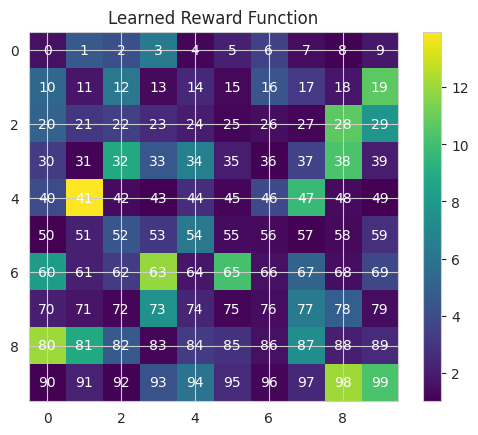

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rewards is the array you provided
rewards = np.array([ 1.59203704,  4.61389421,  4.16548542,  6.40112187,  1.24727198,
        2.13771048,  3.53965901,  1.40704097,  1.05639468,  1.82856364,
        5.30573292,  1.80892933,  6.15090189,  1.34355187,  2.49164726,
        1.28562291,  4.39119801,  3.16419164,  1.78522639, 10.70450158,
        5.07088439,  3.076267  ,  3.46095909,  2.53839712,  2.01752481,
        1.17997368,  1.48550538,  1.23647783, 10.69808468,  7.74354634,
        3.28700516,  1.13181241,  8.87268648,  4.49644818,  6.5722664 ,
        2.05045485,  1.07138624,  3.58774558, 10.30456849,  2.03575344,
        3.97514573, 13.94895507,  1.38776421,  1.02977889,  2.69284211,
        1.1981586 ,  3.83927345,  9.78077595,  1.4045121 ,  1.03290522,
        1.00510489,  2.15508513,  4.45485005,  3.10778638,  6.21019894,
        1.3790585 ,  1.32475199,  1.05576142,  1.30935195,  2.78229562,
        8.09974538,  2.14348899,  3.28503474, 11.92454912,  1.79381089,
       10.18172632,  1.58299368,  5.11976966,  1.49713225,  3.79464248,
        2.08642308,  1.6637715 ,  1.17323995,  7.6535288 ,  2.3367946 ,
        1.22173761,  1.42444388,  6.33050876,  4.85806938,  1.4121078 ,
       12.04672784,  8.85673963,  4.67096092,  1.23129863,  3.29193639,
        2.91727183,  1.59921004,  7.33232529,  2.07643671,  2.54373013,
        1.00059479,  2.21336838,  1.08691557,  4.26405172,  5.95670416,
        2.53991969,  1.22320369,  2.44869331, 12.10828585, 10.26140605])  # Add all the reward values

# Reshape the rewards array into a square matrix for visualization
side_length = int(np.sqrt(len(rewards)))
rewards_matrix = rewards.reshape((side_length, side_length))

fig, ax = plt.subplots()

# Plotting the heatmap
cax = ax.imshow(rewards_matrix, cmap='viridis')

# Adding cluster numbers to each cell
for i in range(side_length):
    for j in range(side_length):
        cluster_number = i * side_length + j
        ax.text(j, i, str(cluster_number), ha='center', va='center', color='w')

# Adding a colorbar
fig.colorbar(cax, ax=ax)

# Setting the title
ax.set_title('Learned Reward Function')

plt.show()


In [ ]:
import seaborn as sns

highest_five_states = np.argsort(reward_maxent_causal)[-5:]

lowest_five_states = np.argsort(reward_maxent_causal)[:5]
selected_states = np.concatenate((lowest_five_states, highest_five_states))
selected_states = selected_states[::-1]
print(reward_maxent_causal[selected_states])
find_cluster_means = data_non_normalized_df.groupby('cluster').mean()
selected_clusters = find_cluster_means.loc[selected_states]

normalized_selected_clusters = (selected_clusters - selected_clusters.min())/ (selected_clusters.max() - selected_clusters.min())
normalized_selected_clusters['bc_policy'] = bc_policy[selected_states]
normalized_selected_clusters['mce_policy'] = policy_mce[selected_states]
selected_clusters['bc_policy'] = bc_policy[selected_states]
selected_clusters['mce_policy'] = policy_mce[selected_states]

plt.figure(figsize=(15, 10))
sns.heatmap(normalized_selected_clusters.T, cbar_kws={'label' : 'Normalized Value for Feature'}, annot=selected_clusters.T, fmt='.1f')
plt.title('Normalized Feature Values for Best and Worst States/Clusters')
plt.ylabel('Feature/Vital Sign')
plt.tight_layout()
plt.savefig('NormalizedFeatures-smoothp25.png')
plt.show()

In [ ]:
policy_mce

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given array
data = np.array([1, 3, 2, 3, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0,
                 0, 0, 3, 2, 2, 2, 1, 2, 1, 0, 0, 3, 2, 1, 2, 2, 2, 0, 2, 0,
                 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 1,
                 3, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 3, 0, 2, 0,
                 2, 0, 3, 2, 2, 2, 0, 3, 1, 2, 0, 2, 0, 3, 2, 0, 0, 3, 0, 1])

# Reshape the array into a 10x10 matrix
matrix = data.reshape((10, 10))

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Use matshow to display the matrix
cax = ax.matshow(matrix, cmap='viridis')

# Add colorbar for reference
fig.colorbar(cax)

# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

# Set tick labels for the grid
ax.set_xticklabels([''] + list(range(1, 11)))
ax.set_yticklabels([''] + list(range(1, 11)))

plt.show()


In [ ]:
policy_mce == data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_policies(policy1, policy2):
    # Normalize the policies
    policy1 /= policy1.sum(axis=1, keepdims=True)
    policy2 /= policy2.sum(axis=1, keepdims=True)

    # Function to calculate entropy of probability distributions
    def calculate_entropy(policy):
        return -np.sum(policy * np.log(policy + 1e-9), axis=1)

    # Calculate entropy for both policies
    entropy1 = calculate_entropy(policy1)
    entropy2 = calculate_entropy(policy2)

    # Calculate preference-based differences
    preference_diff = np.abs(policy1 - policy2)
    overall_diff = np.sum(preference_diff)/policy1.shape[0]
    avg_statewise_diff = np.mean(np.sum(preference_diff, axis=1))
    avg_actionwise_diff = np.mean(preference_diff, axis=0)

    # Compare policies for ability-based differences
    most_probable_action1 = np.argmax(policy1, axis=1)
    most_probable_action2 = np.argmax(policy2, axis=1)
    ability_diff_count = np.sum(most_probable_action1 != most_probable_action2)/policy1.shape[0]

    # Set plot style
    sns.set_style("whitegrid")

    # Plotting entropy of both policies
    plt.figure(figsize=(12, 6), dpi=120)
    plt.plot(entropy1, label='Policy 1 Entropy', color='blue')
    plt.plot(entropy2, label='Policy 2 Entropy', color='red')
    plt.title('Entropy of Policies')
    plt.xlabel('State')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

    # Plotting the average action-wise difference
    plt.figure(figsize=(8, 4))
    sns.barplot(x=np.arange(4), y=avg_actionwise_diff, palette='viridis')
    plt.title('Average Action-wise Preference Difference')
    plt.xlabel('Action')
    plt.ylabel('Average Difference in Probability')
    plt.show()

    # Plotting differences in most probable actions
    plt.figure(figsize=(12, 6), dpi=120)
    plt.plot(most_probable_action1, label='Policy 1 Most Probable Action', color='green')
    plt.plot(most_probable_action2, label='Policy 2 Most Probable Action', color='orange')
    plt.title('Most Probable Actions of Policies')
    plt.xlabel('State')
    plt.ylabel('Most Probable Action')
    plt.legend()
    plt.show()

    # Print the results
    print("Overall Preference Difference:", overall_diff)
    print("Average State-wise Preference Difference:", avg_statewise_diff)
    print("Ability-based Difference Count:", ability_diff_count)



In [ ]:
k_mean_100_base_policy = np.array([[0.25915716, 0.09616153, 0.42627804, 0.21840327],
[0.23267453, 0.18581447, 0.32974777, 0.25176322],
[0.2048565 , 0.25981003, 0.17993809, 0.35539537],
[0.46562245, 0.30461175, 0.10967118, 0.12009461],
[0.11813898, 0.0619814 , 0.49935001, 0.32052961],
[0.37660329, 0.52323665, 0.02617474, 0.07398532],
[0.57367943, 0.17448047, 0.10310351, 0.14873659],
[0.11439677, 0.11933313, 0.44840874, 0.31786135],
[0.05717088, 0.2205141 , 0.39166958, 0.33064543],
[0.09431144, 0.04897025, 0.64860529, 0.20811303],
[0.64053625, 0.29284316, 0.02689954, 0.03972106],
[0.23027129, 0.05574018, 0.49511213, 0.2188764 ],
[0.35996658, 0.29743227, 0.1230119 , 0.21958924],
[0.04408678, 0.0362375 , 0.51841735, 0.40125837],
[0.20433667, 0.20124478, 0.36142002, 0.23299853],
[0.07172022, 0.03607155, 0.67233318, 0.21987505],
[0.31340397, 0.22451299, 0.27107324, 0.19100979],
[0.1715711 , 0.13226192, 0.33945364, 0.35671334],
[0.08804066, 0.07328849, 0.50671364, 0.33195722],
[0.35376188, 0.520316  , 0.02213917, 0.10378295],
[0.54081423, 0.30458265, 0.03988082, 0.1147223 ],
[0.23832995, 0.13450762, 0.31011421, 0.31704822],
[0.32403643, 0.40536801, 0.04534258, 0.22525298],
[0.38978225, 0.09852532, 0.3471304 , 0.16456204],
[0.43624907, 0.49157219, 0.04176657, 0.03041217],
[0.164042  , 0.04568164, 0.44429255, 0.34598382],
[0.08496857, 0.06211449, 0.51338122, 0.33953573],
[0.52349418, 0.37463245, 0.02761374, 0.07425962],
[0.45356185, 0.42967727, 0.04372393, 0.07303696],
[0.41123332, 0.36595818, 0.04235928, 0.18044921],
[0.66010162, 0.23335277, 0.03929823, 0.06724738],
[0.2466499 , 0.17257004, 0.26176522, 0.31901484],
[0.33905797, 0.25946182, 0.17259839, 0.22888182],
[0.51010418, 0.37364966, 0.0618512 , 0.05439496],
[0.26309494, 0.27552765, 0.20077789, 0.26059952],
[0.70764963, 0.1030831 , 0.10637999, 0.08288728],
[0.31822319, 0.36962841, 0.13765356, 0.17449483],
[0.52606029, 0.25705995, 0.10061836, 0.1162614 ],
[0.34524376, 0.44608069, 0.03474203, 0.17393352],
[0.10565627, 0.07246837, 0.48525299, 0.33662236],
[0.52040457, 0.17293992, 0.19239676, 0.11425875],
[0.46754426, 0.39859991, 0.04655683, 0.087299  ],
[0.10644938, 0.0525896 , 0.66608643, 0.17487459],
[0.18811152, 0.10120863, 0.42869012, 0.28198972],
[0.37022052, 0.34179178, 0.12678438, 0.16120333],
[0.10885794, 0.10892466, 0.45736436, 0.32485304],
[0.23486972, 0.12162079, 0.38827226, 0.25523724],
[0.44371878, 0.44433454, 0.04292811, 0.06901857],
[0.07447088, 0.03692868, 0.73402334, 0.1545771 ],
[0.12645591, 0.16244675, 0.35554867, 0.35554867],
[0.25122265, 0.25659953, 0.24608891, 0.24608891],
[0.1358123 , 0.0567727 , 0.64843909, 0.15897592],
[0.24184288, 0.14314008, 0.3733168 , 0.24170024],
[0.13653784, 0.13438503, 0.26210331, 0.46697382],
[0.36651879, 0.39669865, 0.08410715, 0.15267541],
[0.03976856, 0.06673835, 0.46437631, 0.42911677],
[0.08256984, 0.06375506, 0.43932356, 0.41435154],
[0.06387658, 0.15232008, 0.43881042, 0.34499292],
[0.29367185, 0.15032562, 0.40900693, 0.1469956 ],
[0.14536501, 0.11533553, 0.33118935, 0.40811011],
[0.37137205, 0.41263079, 0.07439842, 0.14159873],
[0.17478121, 0.0562701 , 0.57454665, 0.19440205],
[0.38902685, 0.38682531, 0.10433641, 0.11981143],
[0.34573942, 0.46983264, 0.02769167, 0.15673628],
[0.37991041, 0.08996449, 0.31673009, 0.213395  ],
[0.44066194, 0.46868701, 0.02018812, 0.07046293],
[0.65829404, 0.12057439, 0.12827723, 0.09285433],
[0.64719566, 0.25879188, 0.03684314, 0.05716933],
[0.10490992, 0.05046747, 0.54897107, 0.29565153],
[0.32621848, 0.19482516, 0.22098486, 0.2579715 ],
[0.38915168, 0.55105889, 0.01304146, 0.04674797],
[0.08496751, 0.06013096, 0.64731313, 0.2075884 ],
[0.09155237, 0.06303017, 0.48316555, 0.36225191],
[0.4588378 , 0.46934886, 0.02220011, 0.04961322],
[0.1495962 , 0.08483539, 0.52461049, 0.24095791],
[0.31208298, 0.10942021, 0.27458049, 0.30391633],
[0.42523692, 0.19471233, 0.23517989, 0.14487085],
[0.38777993, 0.43037316, 0.0465691 , 0.13527781],
[0.26375184, 0.25751952, 0.24512031, 0.23360833],
[0.09440995, 0.03516589, 0.72794595, 0.14247821],
[0.46682047, 0.42800294, 0.02814515, 0.07703144],
[0.37926324, 0.43669522, 0.07425526, 0.10978628],
[0.46288406, 0.20070275, 0.20060959, 0.1358036 ],
[0.24525752, 0.53286774, 0.10531905, 0.11655568],
[0.16845929, 0.11925929, 0.39673173, 0.31554969],
[0.62449853, 0.28003042, 0.04165663, 0.05381442],
[0.06347537, 0.05710756, 0.52762627, 0.3517908 ],
[0.44143065, 0.45324409, 0.02450306, 0.0808222 ],
[0.12550746, 0.08720199, 0.48887911, 0.29841144],
[0.46048152, 0.31663666, 0.06502648, 0.15785534],
[0.25443912, 0.23668263, 0.25443912, 0.25443912],
[0.31217035, 0.1192627 , 0.35462257, 0.21394437],
[0.08758253, 0.06184875, 0.56563708, 0.28493164],
[0.63124329, 0.24839251, 0.02880347, 0.09156072],
[0.54022816, 0.27954937, 0.07182883, 0.10839364],
[0.62317223, 0.1740008 , 0.09756668, 0.10526028],
[0.03688506, 0.02966746, 0.38478684, 0.54866065],
[0.08579744, 0.07753622, 0.26788504, 0.56878129],
[0.25748142, 0.3618931 , 0.0531338 , 0.32749167],
[0.38779489, 0.46003545, 0.02350654, 0.12866311]])

In [ ]:
kmean_100_costincluded_policy = np.array([[2.89257544e-01, 6.34784624e-01, 6.30285639e-03, 6.96549761e-02],
       [2.20307903e-01, 1.93431757e-01, 2.85003361e-01, 3.01256979e-01],
       [1.14007305e-01, 4.78640545e-02, 5.35864580e-01, 3.02264060e-01],
       [4.25042504e-02, 3.30543979e-02, 4.32067907e-01, 4.92373445e-01],
       [4.71649605e-01, 5.26653142e-01, 1.56403796e-04, 1.54084876e-03],
       [2.30287551e-01, 5.75682310e-02, 5.65904363e-01, 1.46239856e-01],
       [7.64227318e-01, 2.24712517e-01, 4.90842737e-03, 6.15173696e-03],
       [5.45964108e-02, 3.48967463e-02, 6.17322193e-01, 2.93184650e-01],
       [3.91531474e-01, 1.60584922e-01, 2.27756544e-01, 2.20127061e-01],
       [3.09961613e-02, 1.37628334e-02, 6.27400630e-01, 3.27840375e-01],
       [1.95620407e-01, 1.28271596e-01, 3.77391272e-01, 2.98716725e-01],
       [1.18179731e-01, 8.04456959e-01, 7.58906840e-03, 6.97742417e-02],
       [6.93972098e-02, 2.92854995e-02, 7.60693291e-01, 1.40624000e-01],
       [8.60964381e-02, 1.25067242e-01, 3.94418160e-01, 3.94418160e-01],
       [9.65548631e-01, 2.46499582e-02, 1.64135496e-03, 8.16005579e-03],
       [2.11363491e-02, 6.76685828e-03, 9.21747985e-01, 5.03488074e-02],
       [6.67806890e-01, 2.80412951e-01, 9.52510480e-03, 4.22550544e-02],
       [4.62502869e-01, 4.34268469e-01, 4.97891714e-02, 5.34394906e-02],
       [1.54621926e-01, 9.85047896e-02, 4.87287787e-01, 2.59585497e-01],
       [6.87367426e-01, 1.34570381e-01, 1.02170121e-01, 7.58920712e-02],
       [6.21112328e-01, 3.31354270e-01, 4.31847989e-03, 4.32149215e-02],
       [7.48453849e-01, 1.71742764e-01, 2.76941915e-02, 5.21091953e-02],
       [7.62038206e-03, 5.95388271e-03, 3.64511428e-01, 6.21914308e-01],
       [3.79042618e-02, 1.09178576e-02, 8.59294232e-01, 9.18836483e-02],
       [1.17886085e-01, 3.85386694e-02, 4.32280504e-01, 4.11294742e-01],
       [2.53299081e-01, 1.31074202e-01, 3.89189526e-01, 2.26437191e-01],
       [4.68441527e-01, 4.78458336e-01, 3.18862500e-03, 4.99115117e-02],
       [1.48512241e-01, 5.51063290e-02, 5.30691101e-01, 2.65690329e-01],
       [2.94897784e-01, 3.13763854e-01, 1.01661987e-01, 2.89676375e-01],
       [9.43942390e-01, 4.58164159e-02, 6.65456226e-03, 3.58663151e-03],
       [5.65257108e-01, 4.05455717e-01, 2.75530286e-04, 2.90116455e-02],
       [1.33517862e-01, 1.76694976e-01, 1.68102243e-01, 5.21684919e-01],
       [2.44409516e-02, 1.56841326e-02, 6.80209313e-01, 2.79665603e-01],
       [1.05650884e-01, 8.65729372e-01, 3.33633767e-04, 2.82861102e-02],
       [1.16911256e-02, 2.44146781e-02, 5.06722486e-01, 4.57171710e-01],
       [2.80783383e-02, 9.02210325e-03, 8.95551121e-01, 6.73484372e-02],
       [6.94225062e-02, 3.62363996e-02, 6.62172796e-01, 2.32168298e-01],
       [4.89520330e-01, 3.43628289e-01, 7.24531985e-02, 9.43981825e-02],
       [8.14957014e-02, 3.82597413e-02, 7.06874779e-01, 1.73369779e-01],
       [3.83350947e-01, 2.75631450e-01, 6.91452798e-02, 2.71872323e-01],
       [3.69269223e-01, 1.19079801e-01, 1.79003522e-01, 3.32647453e-01],
       [3.73043088e-01, 3.12022825e-01, 1.77493713e-01, 1.37440374e-01],
       [5.06474484e-01, 4.74503696e-01, 5.88589760e-04, 1.84332298e-02],
       [1.21638619e-01, 1.17706232e-01, 5.86921655e-01, 1.73733494e-01],
       [6.72141476e-02, 1.97959916e-02, 7.85105826e-01, 1.27884035e-01],
       [2.16702046e-01, 2.32851665e-02, 6.56228924e-01, 1.03783864e-01],
       [9.57973688e-02, 1.91382748e-02, 5.46650027e-01, 3.38414329e-01],
       [8.84911567e-01, 1.00732407e-01, 7.99747931e-04, 1.35562779e-02],
       [2.45763251e-01, 2.29349617e-01, 2.62443566e-01, 2.62443566e-01],
       [8.69387883e-01, 1.25784552e-01, 1.20302307e-03, 3.62454250e-03],
       [1.74789746e-02, 1.76620824e-02, 6.99846651e-01, 2.65012292e-01],
       [4.31638800e-01, 4.85637164e-01, 2.33762769e-03, 8.03864083e-02],
       [7.84234628e-01, 2.02094451e-01, 4.52165051e-03, 9.14927009e-03],
       [3.93306535e-01, 2.41244500e-01, 1.09149333e-01, 2.56299632e-01],
       [9.48634593e-03, 1.59896746e-02, 5.74424908e-01, 4.00099071e-01],
       [4.14106409e-01, 2.88637570e-01, 1.30155115e-01, 1.67100906e-01],
       [6.00027673e-02, 4.05831681e-02, 4.50147233e-01, 4.49266831e-01],
       [7.55311428e-01, 6.26559693e-02, 1.11588777e-01, 7.04438256e-02],
       [2.07541162e-02, 1.06336995e-02, 6.45067545e-01, 3.23544640e-01],
       [3.55968616e-01, 5.01845388e-01, 5.15912628e-02, 9.05947327e-02],
       [2.08409264e-02, 1.85233551e-02, 2.12695282e-01, 7.47940437e-01],
       [3.18215527e-02, 1.80943699e-02, 6.47290262e-01, 3.02793815e-01],
       [3.31339039e-01, 2.30148531e-01, 2.19256215e-01, 2.19256215e-01],
       [1.52761169e-02, 8.63145452e-03, 5.65969338e-01, 4.10123090e-01],
       [6.17716898e-01, 8.88861136e-02, 1.57617175e-01, 1.35779813e-01],
       [7.77544128e-02, 9.23296459e-02, 5.07598668e-01, 3.22317273e-01],
       [2.98106107e-02, 1.31575255e-02, 7.60207539e-01, 1.96824325e-01],
       [4.25191777e-01, 2.95149995e-01, 2.49168728e-02, 2.54741355e-01],
       [2.90393190e-02, 1.35545545e-02, 6.97635650e-01, 2.59770476e-01],
       [7.22636679e-02, 1.12179970e-02, 6.56671886e-01, 2.59846450e-01],
       [1.68728163e-01, 5.36795318e-02, 6.06280293e-01, 1.71312013e-01],
       [4.49387816e-01, 4.74552521e-01, 3.06129537e-02, 4.54467093e-02],
       [1.35149816e-01, 6.75716041e-02, 5.28476455e-01, 2.68802124e-01],
       [5.58240496e-02, 3.90056912e-02, 6.70549633e-01, 2.34620627e-01],
       [4.95470972e-01, 4.86636964e-01, 1.37189033e-04, 1.77548752e-02],
       [2.55768983e-02, 1.82391606e-01, 4.47001241e-01, 3.45030255e-01],
       [4.69103702e-02, 3.90799743e-02, 1.38682783e-01, 7.75326872e-01],
       [5.30474234e-01, 4.10209490e-01, 5.96804971e-03, 5.33482262e-02],
       [2.45176176e-02, 1.41819528e-01, 4.81735646e-01, 3.51927208e-01],
       [8.60731031e-01, 1.35252987e-01, 6.87686476e-04, 3.32829627e-03],
       [3.53051950e-02, 2.63218197e-02, 5.14077116e-01, 4.24295869e-01],
       [4.73432761e-01, 3.74403555e-01, 3.17357831e-02, 1.20427901e-01],
       [3.12343734e-02, 3.27149742e-02, 4.54415212e-01, 4.81635441e-01],
       [8.46405284e-02, 2.25989225e-02, 7.35878833e-01, 1.56881716e-01],
       [2.03913238e-01, 8.73063075e-02, 3.89093562e-01, 3.19686892e-01],
       [6.71612939e-02, 4.33209828e-02, 5.06475752e-01, 3.83041972e-01],
       [3.97126791e-01, 3.59797957e-02, 3.81293043e-01, 1.85600371e-01],
       [2.74847277e-01, 1.76518582e-01, 1.98391228e-01, 3.50242913e-01],
       [4.24917690e-01, 5.57203480e-01, 3.31188164e-03, 1.45669484e-02],
       [1.21626194e-01, 9.47657848e-02, 5.35883752e-01, 2.47724269e-01],
       [6.85051885e-01, 2.95882109e-01, 1.76006878e-03, 1.73059371e-02],
       [5.73814402e-02, 1.87480415e-02, 6.10596056e-01, 3.13274462e-01],
       [4.16506271e-01, 1.94972084e-01, 1.79146232e-01, 2.09375413e-01],
       [1.57364926e-01, 2.33970077e-01, 1.74251563e-01, 4.34413434e-01],
       [1.93744140e-02, 8.08625549e-03, 9.04510277e-01, 6.80290539e-02],
       [6.42667235e-01, 2.08148095e-01, 7.24101888e-02, 7.67744812e-02],
       [4.97339466e-01, 3.44563487e-01, 9.51991458e-02, 6.28979011e-02],
       [3.39503256e-01, 3.05759850e-01, 1.18423807e-02, 3.42894514e-01],
       [6.97896148e-01, 2.50780493e-01, 1.45422130e-02, 3.67811458e-02],
       [2.72835012e-01, 3.41809456e-01, 6.59235361e-02, 3.19431996e-01]])

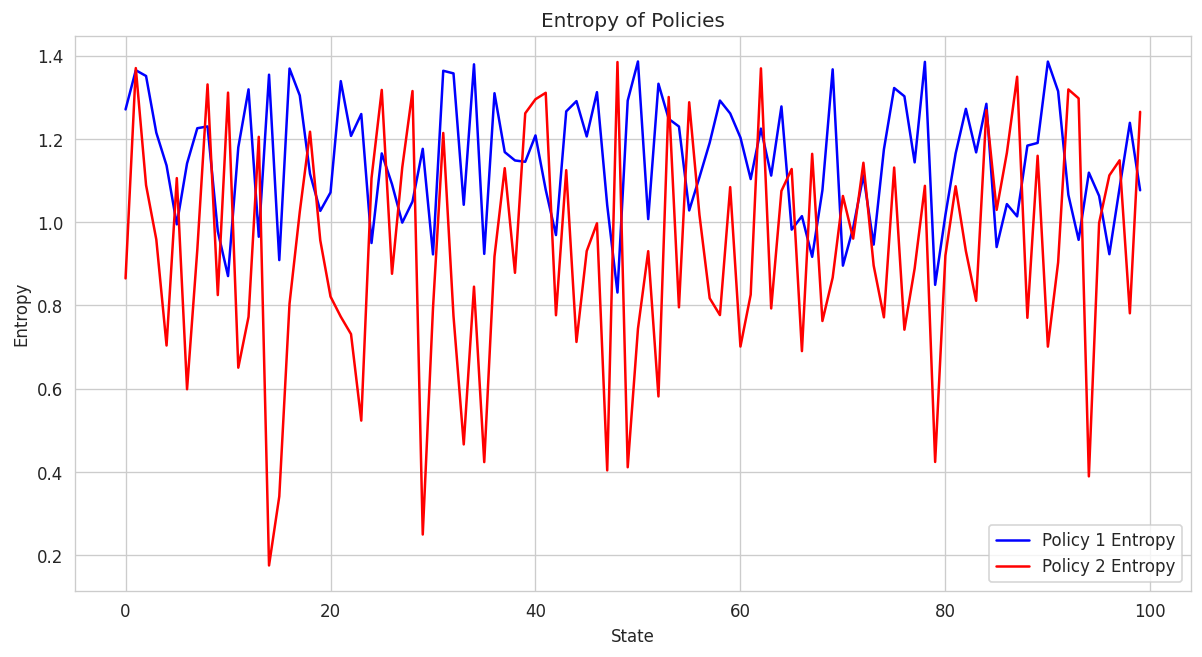

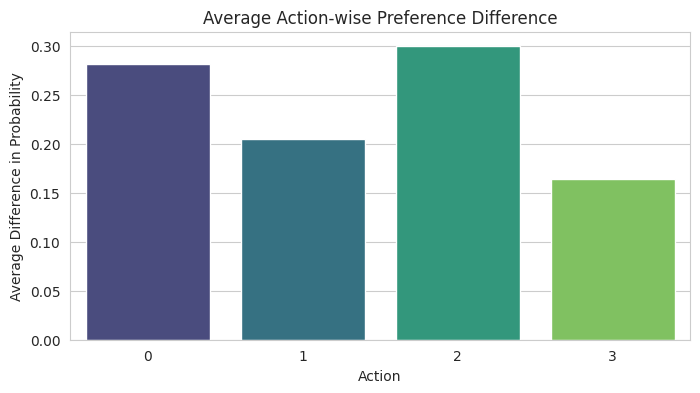

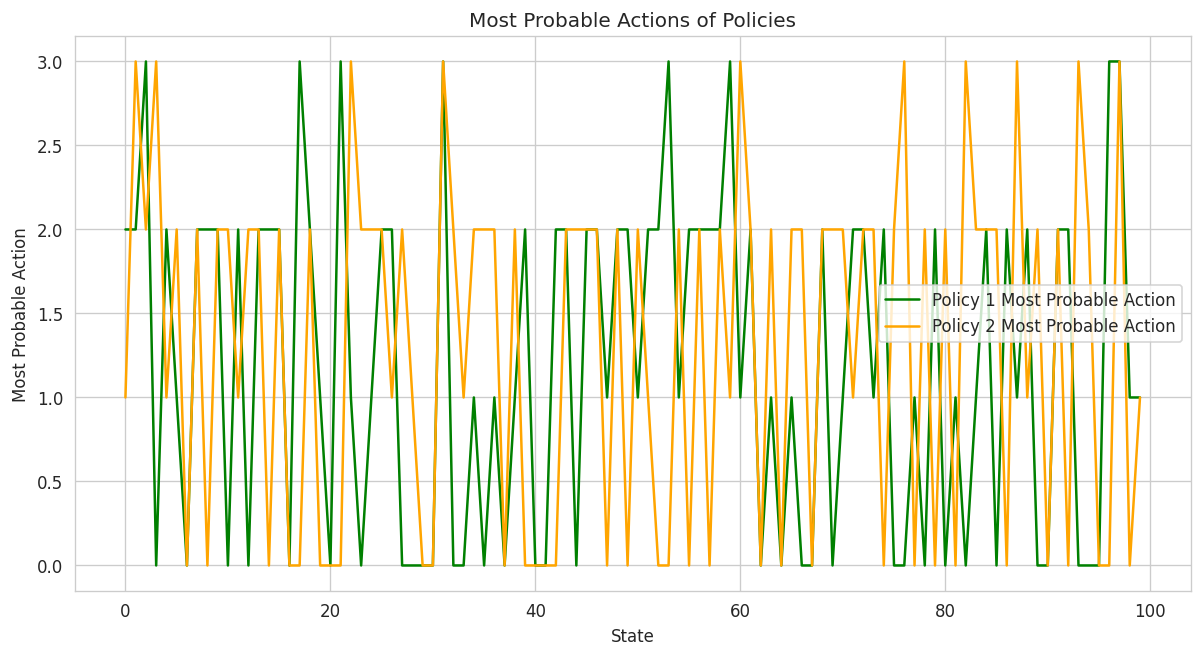

Overall Preference Difference: 0.949398858978952
Average State-wise Preference Difference: 0.9493988589789519
Ability-based Difference Count: 0.67


In [ ]:
compare_policies(k_mean_100_base_policy, kmean_100_costincluded_policy)